# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3137.37it/s]


In [23]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [6]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [42]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

In [2]:
# after preprocessing 
df = pd.read_pickle("files/preprocessed.pkl")
df.shape

(364171, 12)

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...,love book miss hard cover version
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,chicken soup rice months
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read aloud nice rhythm well ...,good swingy rhythm reading aloud
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...,great way learn months


In [48]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , f1_score , confusion_matrix
from collections import Counter
from sklearn.metrics import accuracy_score, roc_auc_score , roc_curve
from sklearn.model_selection import train_test_split

In [49]:
# take 50k sample data randomly
sample_data = df.sample(100000)
sample_data.shape

(100000, 12)

In [50]:
# sorted the data using time based
sorted_data = sample_data.sort_values('Time', axis=0, inplace=False)
sorted_data.shape

(100000, 12)

In [51]:
sorted_data['Score'].value_counts()

1    84429
0    15571
Name: Score, dtype: int64

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
X = np.array(sorted_data['CleanedText'])
y = np.array(sorted_data['Score'])
print(X.shape)
print(y.shape)

(100000,)
(100000,)


In [54]:
# Simple cross validation
# split the data sent into train and test
train , test , train_y , test_y = train_test_split(X, y, test_size = 0.3, random_state=None)

# split the train data set into cross validation train and cross validation test
train, cv , train_y, cv_y = train_test_split(train, train_y, test_size=0.3, random_state=None)

print("train data = ", train.shape)
print("cros validation = ", cv.shape)
print("test data = ", test.shape)

train data =  (49000,)
cros validation =  (21000,)
test data =  (30000,)


## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [3]:
# Please write all the code with proper documentation

In [15]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
#BoW
count_vect = CountVectorizer(min_df=10) #in scikit-learn
count_vect.fit(train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bow_train = count_vect.fit_transform(train)
bow_cv = count_vect.transform(cv)
bow_test = count_vect.transform(test)
print("============Train Data=========")
print("the type of count vectorizer ",type(bow_train))
print("the shape of out text BOW vectorizer ",bow_train.get_shape())
print("the number of unique words ", bow_train.get_shape()[1])
print("============Cross validation Data=========")
print("the type of count vectorizer ",type(bow_cv))
print("the shape of out text BOW vectorizer ",bow_cv.get_shape())
print("the number of unique words ", bow_cv.get_shape()[1])
print("============Test Data=========")
print("the type of count vectorizer ",type(bow_test))
print("the shape of out text BOW vectorizer ",bow_test.get_shape())
print("the number of unique words ", bow_test.get_shape()[1])

some feature names  ['aa', 'ability', 'able', 'abroad', 'absent', 'absolute', 'absolutely', 'absolutly', 'absorb', 'absorbed']
============Train Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (49000, 8771)
the number of unique words  8771
============Cross validation Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (21000, 8771)
the number of unique words  8771
============Test Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (30000, 8771)
the number of unique words  8771


In [61]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

#### using L2 reglirization

In [37]:
alpha = [pow(10,j) for j in range(-4,4,1)]

bow_train_auc = []
bow_cv_auc = []
for i in alpha:
    LSVM = SGDClassifier(loss='hinge',alpha=i, penalty='l2')
    calibrated_clf = CalibratedClassifierCV(LSVM, cv=5, method='sigmoid')
    calibrated_clf.fit(bow_train, train_y)
    # train data
    y_prob_train = calibrated_clf.predict_proba(bow_train)[:,1]
    y_pred = np.where(y_prob_train > 0.5, 1, 0)
    auc_roc_train = roc_auc_score(train_y , y_prob_train)
    print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
    bow_train_auc.append(auc_roc_train)
    # CV
    y_prob_cv = calibrated_clf.predict_proba(bow_cv)[:,1]
    y_pred = np.where(y_prob_cv > 0.5, 1, 0)
    auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
    print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
    bow_cv_auc.append(auc_roc_cv)
    print("="*50)



Train AUC for λ = 0.0001 is 97.49%

CV AUC for λ = 0.0001 is 93.87%

Train AUC for λ = 0.001 is 96.37%

CV AUC for λ = 0.001 is 94.19%

Train AUC for λ = 0.01 is 93.49%

CV AUC for λ = 0.01 is 92.52%

Train AUC for λ = 0.1 is 78.23%

CV AUC for λ = 0.1 is 77.48%

Train AUC for λ = 1 is 52.53%

CV AUC for λ = 1 is 52.90%

Train AUC for λ = 10 is 55.79%

CV AUC for λ = 10 is 55.25%

Train AUC for λ = 100 is 56.10%

CV AUC for λ = 100 is 55.56%

Train AUC for λ = 1000 is 56.10%

CV AUC for λ = 1000 is 55.56%


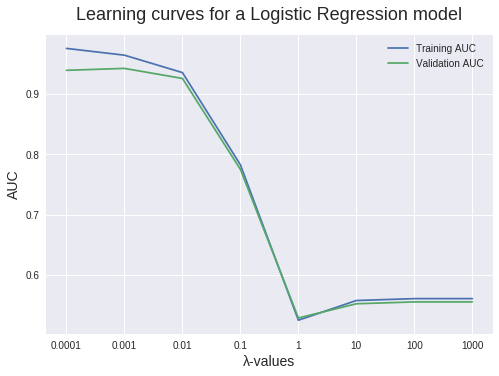

In [38]:
hyper = [str(pow(10,j)) for j in range(-4,4)]

# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(hyper,bow_train_auc,label = 'Training AUC')
plt.plot(hyper, bow_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('\u03BB-values', fontsize = 14)
plt.title('Learning curves for a Logistic Regression model', fontsize = 18, y = 1.03)
plt.legend()

In [39]:
i = 0.001
LSVM = SGDClassifier(loss='hinge',alpha=i, penalty='l2')
calibrated_clf = CalibratedClassifierCV(LSVM, cv=5, method='sigmoid')
calibrated_clf.fit(bow_train, train_y)
# train data
y_prob_train = calibrated_clf.predict_proba(bow_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
# CV
y_prob_cv = calibrated_clf.predict_proba(bow_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
# Test
y_prob_test = calibrated_clf.predict_proba(bow_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))
                                              


Train AUC for λ = 0.001 is 96.40%

CV AUC for λ = 0.001 is 94.19%

Test AUC for λ = 0.001 is 93.92%


In [64]:
LSVM = SGDClassifier(loss='hinge',alpha=0.001, penalty='l2')
LSVM.fit(bow_train, train_y)

# number of non-zero weights
w = LSVM.coef_
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of non-zero weights :  8738


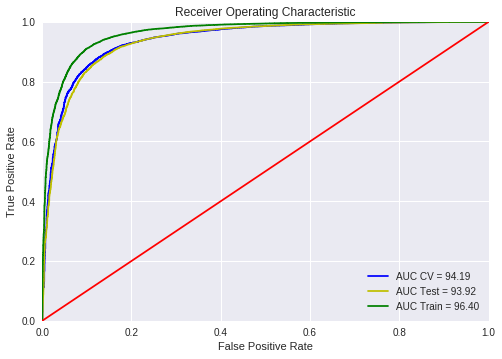

In [41]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [42]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.95


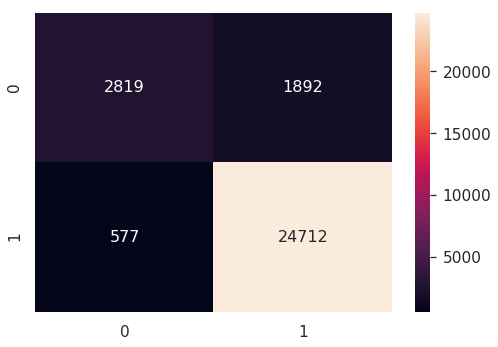

In [43]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

#### Top 10 important features of positive class

In [67]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
feture_weights = w.tolist()[0]
feature_names = count_vect.get_feature_names()
features = dict(zip(feture_weights,feature_names))

In [68]:
features_df = pd.DataFrame.from_dict(features, orient='index')
sorted_features = features_df.sort_index(axis=0,ascending=False )

In [69]:
sorted_features.head(10)

,0
0.619961,excellent
0.611803,delicious
0.554702,highly
0.534308,perfect
0.526151,awesome
0.501679,smooth
0.497600,best
0.489443,amazing
0.485364,pleased
0.469049,great


### Top 10 important features of negative class from

In [70]:
# Please write all the code with proper documentation
sorted_features = features_df.sort_index(axis=0,ascending=True)
sorted_features.head(10)

,0
-1.007436,worst
-0.880997,disappointing
-0.876918,terrible
-0.856525,disappointed
-0.758636,horrible
-0.754557,unfortunately
-0.738243,threw
-0.681141,return
-0.664826,disappointment
-0.624039,stale


#### using L1 regulirization

In [32]:
alpha = [pow(10,j) for j in range(-4,4,1)]

bow_train_auc = []
bow_cv_auc = []
for i in alpha:
    LSVM = SGDClassifier(loss='hinge',alpha=i, penalty='l1')
    calibrated_clf = CalibratedClassifierCV(LSVM, cv=5, method='sigmoid')
    calibrated_clf.fit(bow_train, train_y)
    # train data
    y_prob_train = calibrated_clf.predict_proba(bow_train)[:,1]
    y_pred = np.where(y_prob_train > 0.5, 1, 0)
    auc_roc_train = roc_auc_score(train_y , y_prob_train)
    print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
    bow_train_auc.append(auc_roc_train)
    # CV
    y_prob_cv = calibrated_clf.predict_proba(bow_cv)[:,1]
    y_pred = np.where(y_prob_cv > 0.5, 1, 0)
    auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
    print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
    bow_cv_auc.append(auc_roc_cv)
    print("="*50)



Train AUC for λ = 0.0001 is 95.73%

CV AUC for λ = 0.0001 is 93.49%

Train AUC for λ = 0.001 is 91.17%

CV AUC for λ = 0.001 is 90.66%

Train AUC for λ = 0.01 is 70.50%

CV AUC for λ = 0.01 is 69.82%

Train AUC for λ = 0.1 is 54.77%

CV AUC for λ = 0.1 is 54.42%

Train AUC for λ = 1 is 50.00%

CV AUC for λ = 1 is 50.00%

Train AUC for λ = 10 is 50.00%

CV AUC for λ = 10 is 50.00%

Train AUC for λ = 100 is 50.00%

CV AUC for λ = 100 is 50.00%

Train AUC for λ = 1000 is 50.00%

CV AUC for λ = 1000 is 50.00%


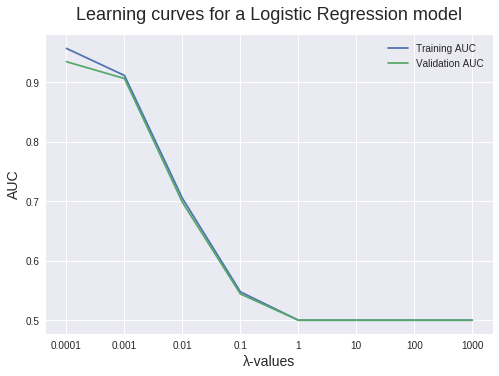

In [33]:
hyper = [str(pow(10,j)) for j in range(-4,4)]

# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(hyper,bow_train_auc,label = 'Training AUC')
plt.plot(hyper, bow_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('\u03BB-values', fontsize = 14)
plt.title('Learning curves for a Logistic Regression model', fontsize = 18, y = 1.03)
plt.legend()

In [34]:
i = 0.0001
LSVM = SGDClassifier(loss='hinge',alpha=i, penalty='l1')
calibrated_clf = CalibratedClassifierCV(LSVM, cv=5, method='sigmoid')
calibrated_clf.fit(bow_train, train_y)
# train data
y_prob_train = calibrated_clf.predict_proba(bow_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
# CV
y_prob_cv = calibrated_clf.predict_proba(bow_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
# Test
y_prob_test = calibrated_clf.predict_proba(bow_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))
                                              


Train AUC for λ = 0.0001 is 95.77%

CV AUC for λ = 0.0001 is 93.50%

Test AUC for λ = 0.0001 is 93.07%


In [46]:
LSVM = SGDClassifier(loss='hinge',alpha=0.0001, penalty='l1')
LSVM.fit(bow_train, train_y)

# number of non-zero weights
w = LSVM.coef_
print("Number of weights : ", w.shape[1])
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of weights :  8771
Number of non-zero weights :  2306


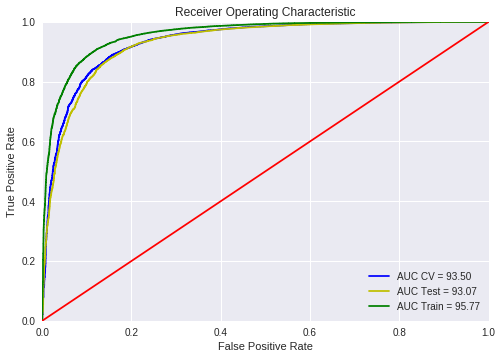

In [36]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [44]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.95


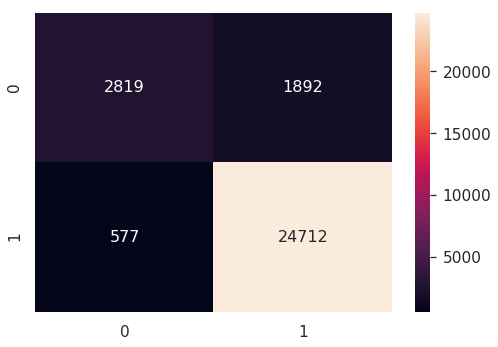

In [45]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [47]:
# Please write all the code with proper documentation

model = TfidfVectorizer(min_df=20, ngram_range=(1,2))
#tf_idf_matrix = model.fit_transform(train)

print("================Train Data===========")
tf_idf_train = model.fit_transform(train)
print("the type of count vectorizer ",type(tf_idf_train))
print("the shape of out text TFIDF vectorizer ",tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ",tf_idf_train.get_shape()[1])
print("================CV Data===========")
tf_idf_cv = model.transform(cv)
print("the type of count vectorizer ",type(tf_idf_cv))
print("the shape of out text TFIDF vectorizer ",tf_idf_cv.get_shape())
print("the number of unique words including both unigrams and bigrams ",tf_idf_cv.get_shape()[1])
print("================Test Data===========")
tf_idf_test = model.transform(test)
print("the type of count vectorizer ",type(tf_idf_test))
print("the shape of out text TFIDF vectorizer ",tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", tf_idf_test.get_shape()[1])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

================Train Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (49000, 13648)
the number of unique words including both unigrams and bigrams  13648
================CV Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (21000, 13648)
the number of unique words including both unigrams and bigrams  13648
================Test Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (30000, 13648)
the number of unique words including both unigrams and bigrams  13648


In [51]:
alpha = [pow(10,j) for j in range(-4,4,1)]

tfidf_train_auc = []
tfidf_cv_auc = []
for i in alpha:
    LSVM = SGDClassifier(loss='hinge',alpha=i, penalty='l2')
    calibrated_clf = CalibratedClassifierCV(LSVM, cv=5, method='sigmoid')
    calibrated_clf.fit(tf_idf_train, train_y)
    # train data
    y_prob_train = calibrated_clf.predict_proba(tf_idf_train)[:,1]
    y_pred = np.where(y_prob_train > 0.5, 1, 0)
    auc_roc_train = roc_auc_score(train_y , y_prob_train)
    print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
    tfidf_train_auc.append(auc_roc_train)
    # CV
    y_prob_cv = calibrated_clf.predict_proba(tf_idf_cv)[:,1]
    y_pred = np.where(y_prob_cv > 0.5, 1, 0)
    auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
    print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
    tfidf_cv_auc.append(auc_roc_cv)
    print("="*50)



Train AUC for λ = 0.0001 is 97.29%

CV AUC for λ = 0.0001 is 95.73%

Train AUC for λ = 0.001 is 96.14%

CV AUC for λ = 0.001 is 95.00%

Train AUC for λ = 0.01 is 96.17%

CV AUC for λ = 0.01 is 95.04%

Train AUC for λ = 0.1 is 61.07%

CV AUC for λ = 0.1 is 61.09%

Train AUC for λ = 1 is 61.07%

CV AUC for λ = 1 is 61.09%

Train AUC for λ = 10 is 61.07%

CV AUC for λ = 10 is 61.09%

Train AUC for λ = 100 is 61.07%

CV AUC for λ = 100 is 61.09%

Train AUC for λ = 1000 is 61.07%

CV AUC for λ = 1000 is 61.09%


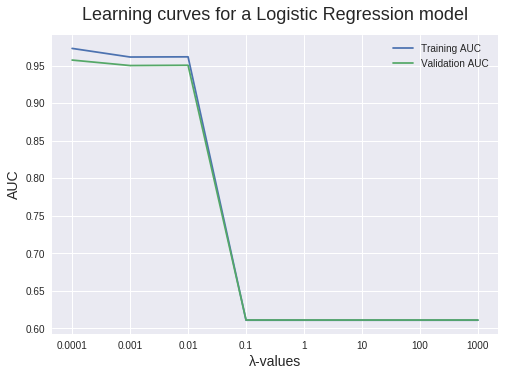

In [52]:
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(hyper,tfidf_train_auc,label = 'Training AUC')
plt.plot(hyper, tfidf_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('\u03BB-values', fontsize = 14)
plt.title('Learning curves for a Logistic Regression model', fontsize = 18, y = 1.03)
plt.legend()

In [53]:
i = 0.0001
LSVM = SGDClassifier(loss='hinge',alpha=i, penalty='l2')
calibrated_clf = CalibratedClassifierCV(LSVM, cv=5, method='sigmoid')
calibrated_clf.fit(tf_idf_train, train_y)
# train data
y_prob_train = calibrated_clf.predict_proba(tf_idf_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
# CV
y_prob_cv = calibrated_clf.predict_proba(tf_idf_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
# Test
y_prob_test = calibrated_clf.predict_proba(tf_idf_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))
                                              


Train AUC for λ = 0.0001 is 97.29%

CV AUC for λ = 0.0001 is 95.72%

Test AUC for λ = 0.0001 is 95.82%


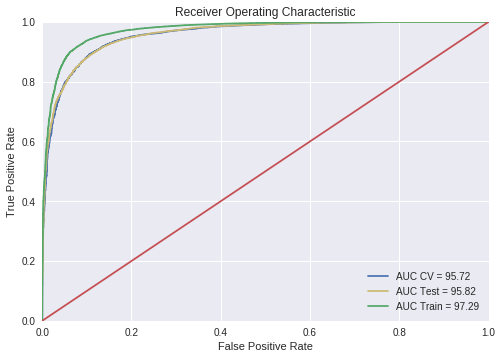

In [54]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [55]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.96


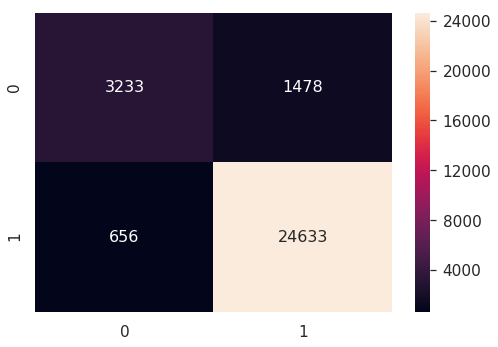

In [56]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

In [71]:
LSVM = SGDClassifier(loss='hinge',alpha=0.0001, penalty='l2')
LSVM.fit(tf_idf_train, train_y)

# number of non-zero weights
w = LSVM.coef_
print("Number of weights : ", w.shape[1])
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of weights :  13648
Number of non-zero weights :  13626


#### Top 10 important features of positive class 

In [72]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
feture_weights = w.tolist()[0]
feature_names = model.get_feature_names()
features = dict(zip(feture_weights,feature_names))

In [73]:
features_df = pd.DataFrame.from_dict(features, orient='index')
sorted_features = features_df.sort_index(axis=0,ascending=False )

In [74]:
sorted_features.head(10)

,0
3.520651,great
2.848719,best
2.816173,not disappointed
2.658403,delicious
2.384709,good
2.140364,perfect
2.136886,love
2.105295,excellent
1.771214,tasty
1.736261,loves


### Top 10 important features of negative class

In [75]:
# Please write all the code with proper documentation
sorted_features = features_df.sort_index(axis=0,ascending=True)
sorted_features.head(10)

,0
-4.553429,disappointed
-3.342798,worst
-3.265935,terrible
-3.085888,awful
-2.990699,not buy
-2.934224,horrible
-2.857275,not worth
-2.834140,not good
-2.823619,disappointing
-2.783166,not


#### using L1 regulirization

In [57]:
alpha = [pow(10,j) for j in range(-4,4,1)]

tfidf_train_auc = []
tfidf_cv_auc = []
for i in alpha:
    LSVM = SGDClassifier(loss='hinge',alpha=i, penalty='l1')
    calibrated_clf = CalibratedClassifierCV(LSVM, cv=5, method='sigmoid')
    calibrated_clf.fit(tf_idf_train, train_y)
    # train data
    y_prob_train = calibrated_clf.predict_proba(tf_idf_train)[:,1]
    y_pred = np.where(y_prob_train > 0.5, 1, 0)
    auc_roc_train = roc_auc_score(train_y , y_prob_train)
    print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
    tfidf_train_auc.append(auc_roc_train)
    # CV
    y_prob_cv = calibrated_clf.predict_proba(tf_idf_cv)[:,1]
    y_pred = np.where(y_prob_cv > 0.5, 1, 0)
    auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
    print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
    tfidf_cv_auc.append(auc_roc_cv)
    print("="*50)



Train AUC for λ = 0.0001 is 94.34%

CV AUC for λ = 0.0001 is 93.81%

Train AUC for λ = 0.001 is 76.74%

CV AUC for λ = 0.001 is 76.31%

Train AUC for λ = 0.01 is 50.00%

CV AUC for λ = 0.01 is 50.00%

Train AUC for λ = 0.1 is 50.00%

CV AUC for λ = 0.1 is 50.00%

Train AUC for λ = 1 is 50.00%

CV AUC for λ = 1 is 50.00%

Train AUC for λ = 10 is 50.00%

CV AUC for λ = 10 is 50.00%

Train AUC for λ = 100 is 50.00%

CV AUC for λ = 100 is 50.00%

Train AUC for λ = 1000 is 50.00%

CV AUC for λ = 1000 is 50.00%


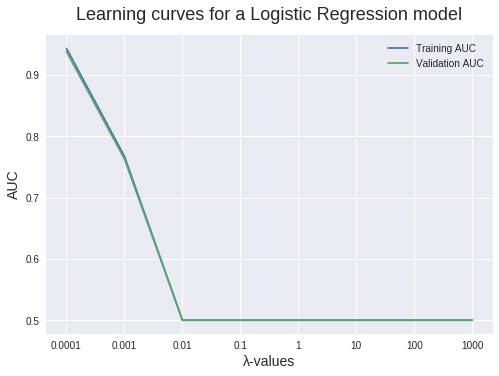

In [58]:
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(hyper,tfidf_train_auc,label = 'Training AUC')
plt.plot(hyper, tfidf_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('\u03BB-values', fontsize = 14)
plt.title('Learning curves for a Logistic Regression model', fontsize = 18, y = 1.03)
plt.legend()

In [59]:
i = 0.0001
LSVM = SGDClassifier(loss='hinge',alpha=i, penalty='l1')
calibrated_clf = CalibratedClassifierCV(LSVM, cv=5, method='sigmoid')
calibrated_clf.fit(tf_idf_train, train_y)
# train data
y_prob_train = calibrated_clf.predict_proba(tf_idf_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
# CV
y_prob_cv = calibrated_clf.predict_proba(tf_idf_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
# Test
y_prob_test = calibrated_clf.predict_proba(tf_idf_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))
                                              


Train AUC for λ = 0.0001 is 94.32%

CV AUC for λ = 0.0001 is 93.80%

Test AUC for λ = 0.0001 is 93.97%


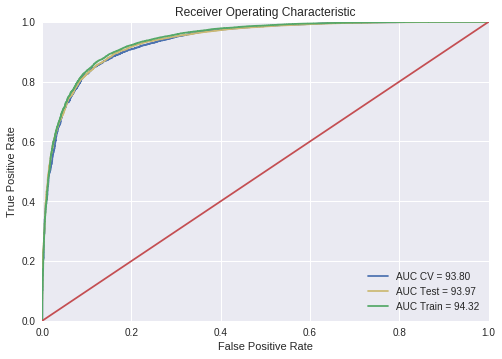

In [60]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [61]:
LSVM = SGDClassifier(loss='hinge',alpha=0.0001, penalty='l1')
LSVM.fit(tf_idf_train, train_y)

# number of non-zero weights
w = LSVM.coef_
print("Number of weights : ", w.shape[1])
print("Number of non-zero weights : ",np.count_nonzero(w))

Number of weights :  13648
Number of non-zero weights :  397


In [62]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.95


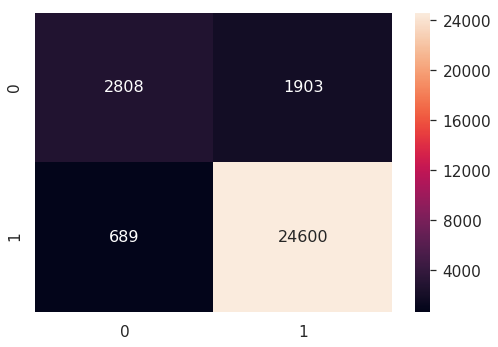

In [63]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [76]:
# Train your own Word2Vec model using your own text corpus
######## Train Set #########
i=0
list_of_train_sentance=[]
for sentance in train:
    list_of_train_sentance.append(sentance.split())
######## CV Set ###########
i=0
list_of_cv_sentance=[]
for sentance in cv:
    list_of_cv_sentance.append(sentance.split())
######## Test Set #########
i=0
list_of_test_sentance=[]
for sentance in test:
    list_of_test_sentance.append(sentance.split())
print("Length of Train = ", len(list_of_train_sentance))
print("Length of CV = ", len(list_of_cv_sentance))
print("Length of Test = ", len(list_of_test_sentance))

Length of Train =  49000
Length of CV =  21000
Length of Test =  30000


In [77]:
w2v_model=Word2Vec(list_of_train_sentance,min_count=15,size=100, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

[('terrific', 0.7772042751312256), ('excellent', 0.7740203142166138), ('fantastic', 0.7613747119903564), ('wonderful', 0.7594865560531616), ('awesome', 0.7251150608062744), ('good', 0.720509946346283), ('perfect', 0.6628544330596924), ('amazing', 0.6120957136154175), ('incredible', 0.5995569229125977), ('fabulous', 0.585849404335022)]
[('best', 0.7626129984855652), ('greatest', 0.7530427575111389), ('tastiest', 0.6860834956169128), ('closest', 0.6559862494468689), ('smoothest', 0.644377589225769), ('superior', 0.617792546749115), ('disgusting', 0.5788611769676208), ('richest', 0.5728204250335693), ('worse', 0.5606545209884644), ('awful', 0.5551104545593262)]


In [78]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  7492
sample words  ['fully', 'intended', 'take', 'work', 'share', 'friend', 'addictive', 'ended', 'eating', 'home', 'ordered', 'chocolates', 'saw', 'used', 'show', 'touted', 'one', 'best', 'around', 'several', 'offset', 'shipping', 'costs', 'arrived', 'excellent', 'condition', 'packaged', 'well', 'remained', 'intact', 'expensive', 'expected', 'pure', 'bliss', 'found', 'okay', 'not', 'compelled', 'order', 'yet', 'tried', 'wonderful', 'pistachios', 'waiting', 'cashew', 'nut', 'guy', 'changed', 'bit', 'pricier']


In [79]:
######## Train data ########
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_train_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 49000/49000 [02:16<00:00, 407.72it/s]

49000
100


In [80]:
######## CV data ########
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_cv_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|██████████| 21000/21000 [00:58<00:00, 356.99it/s]

21000
100


In [81]:
######## Test data ########
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_test_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 30000/30000 [01:20<00:00, 372.50it/s]

30000
100


In [82]:
# save the datasets as numpy array
w2v_train = np.array(sent_vectors_train)
w2v_cv = np.array(sent_vectors_cv)
w2v_test = np.array(sent_vectors_test)

### Using L2 regularization

In [87]:
alpha = [pow(10,j) for j in range(-4,4,1)]

w2v_train_auc = []
w2v_cv_auc = []
for i in alpha:
    LSVM = SGDClassifier(loss='hinge',alpha=i, penalty='l2')
    calibrated_clf = CalibratedClassifierCV(LSVM, cv=5, method='sigmoid')
    calibrated_clf.fit(w2v_train, train_y)
    # train data
    y_prob_train = calibrated_clf.predict_proba(w2v_train)[:,1]
    y_pred = np.where(y_prob_train > 0.5, 1, 0)
    auc_roc_train = roc_auc_score(train_y , y_prob_train)
    print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
    w2v_train_auc.append(auc_roc_train)
    # CV
    y_prob_cv = calibrated_clf.predict_proba(w2v_cv)[:,1]
    y_pred = np.where(y_prob_cv > 0.5, 1, 0)
    auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
    print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
    w2v_cv_auc.append(auc_roc_cv)
    print("="*50)


Train AUC for λ = 0.0001 is 91.25%

CV AUC for λ = 0.0001 is 91.26%

Train AUC for λ = 0.001 is 91.16%

CV AUC for λ = 0.001 is 91.19%

Train AUC for λ = 0.01 is 90.69%

CV AUC for λ = 0.01 is 90.67%

Train AUC for λ = 0.1 is 90.51%

CV AUC for λ = 0.1 is 90.48%

Train AUC for λ = 1 is 90.49%

CV AUC for λ = 1 is 90.48%

Train AUC for λ = 10 is 83.90%

CV AUC for λ = 10 is 83.83%

Train AUC for λ = 100 is 65.58%

CV AUC for λ = 100 is 65.29%

Train AUC for λ = 1000 is 65.58%

CV AUC for λ = 1000 is 65.29%


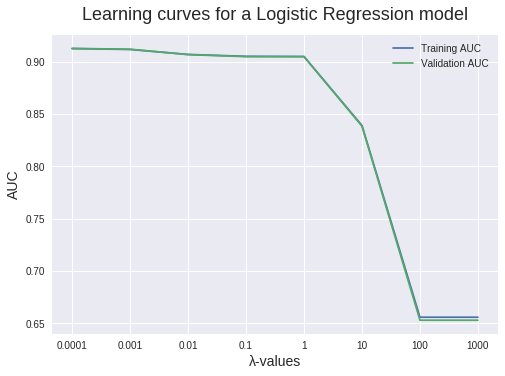

In [88]:
hyper = [str(pow(10,j)) for j in range(-4,4)]
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(hyper,w2v_train_auc,label = 'Training AUC')
plt.plot(hyper, w2v_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('\u03BB-values', fontsize = 14)
plt.title('Learning curves for a Logistic Regression model', fontsize = 18, y = 1.03)
plt.legend()

In [90]:
i = 0.0001
LSVM = SGDClassifier(loss='hinge',alpha=i, penalty='l2')
calibrated_clf = CalibratedClassifierCV(LSVM, cv=5, method='sigmoid')
calibrated_clf.fit(w2v_train, train_y)
# train data
y_prob_train = calibrated_clf.predict_proba(w2v_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
# CV
y_prob_cv = calibrated_clf.predict_proba(w2v_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
# Test
y_prob_test = calibrated_clf.predict_proba(w2v_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))
                                              


Train AUC for λ = 0.0001 is 91.20%

CV AUC for λ = 0.0001 is 91.26%

Test AUC for λ = 0.0001 is 91.17%


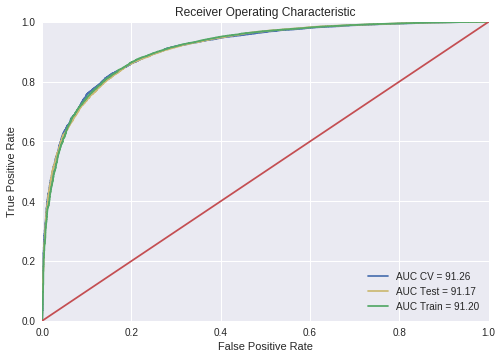

In [91]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [92]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.94


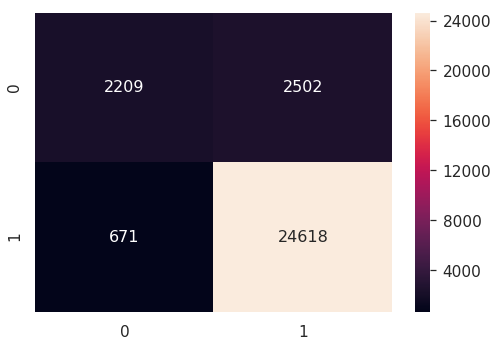

In [93]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

### using L1 

In [94]:
alpha = [pow(10,j) for j in range(-4,4,1)]

w2v_train_auc = []
w2v_cv_auc = []
for i in alpha:
    LSVM = SGDClassifier(loss='hinge',alpha=i, penalty='l1')
    calibrated_clf = CalibratedClassifierCV(LSVM, cv=5, method='sigmoid')
    calibrated_clf.fit(w2v_train, train_y)
    # train data
    y_prob_train = calibrated_clf.predict_proba(w2v_train)[:,1]
    y_pred = np.where(y_prob_train > 0.5, 1, 0)
    auc_roc_train = roc_auc_score(train_y , y_prob_train)
    print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
    w2v_train_auc.append(auc_roc_train)
    # CV
    y_prob_cv = calibrated_clf.predict_proba(w2v_cv)[:,1]
    y_pred = np.where(y_prob_cv > 0.5, 1, 0)
    auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
    print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
    w2v_cv_auc.append(auc_roc_cv)
    print("="*50)


Train AUC for λ = 0.0001 is 90.96%

CV AUC for λ = 0.0001 is 91.07%

Train AUC for λ = 0.001 is 90.75%

CV AUC for λ = 0.001 is 90.77%

Train AUC for λ = 0.01 is 86.41%

CV AUC for λ = 0.01 is 86.68%

Train AUC for λ = 0.1 is 50.00%

CV AUC for λ = 0.1 is 50.00%

Train AUC for λ = 1 is 50.00%

CV AUC for λ = 1 is 50.00%

Train AUC for λ = 10 is 50.00%

CV AUC for λ = 10 is 50.00%

Train AUC for λ = 100 is 50.00%

CV AUC for λ = 100 is 50.00%

Train AUC for λ = 1000 is 50.00%

CV AUC for λ = 1000 is 50.00%


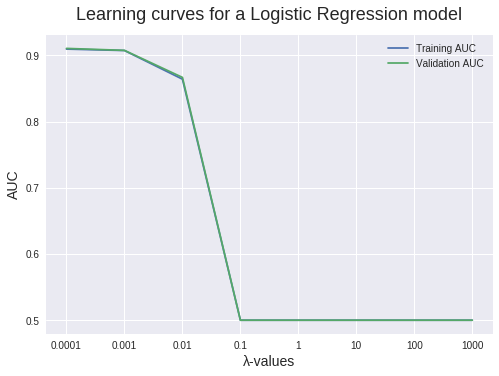

In [95]:
hyper = [str(pow(10,j)) for j in range(-4,4)]
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(hyper,w2v_train_auc,label = 'Training AUC')
plt.plot(hyper, w2v_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('\u03BB-values', fontsize = 14)
plt.title('Learning curves for a Logistic Regression model', fontsize = 18, y = 1.03)
plt.legend()

In [96]:
i = 0.0001
LSVM = SGDClassifier(loss='hinge',alpha=i, penalty='l1')
calibrated_clf = CalibratedClassifierCV(LSVM, cv=5, method='sigmoid')
calibrated_clf.fit(w2v_train, train_y)
# train data
y_prob_train = calibrated_clf.predict_proba(w2v_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
# CV
y_prob_cv = calibrated_clf.predict_proba(w2v_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
# Test
y_prob_test = calibrated_clf.predict_proba(w2v_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))
                                              


Train AUC for λ = 0.0001 is 91.18%

CV AUC for λ = 0.0001 is 91.10%

Test AUC for λ = 0.0001 is 91.15%


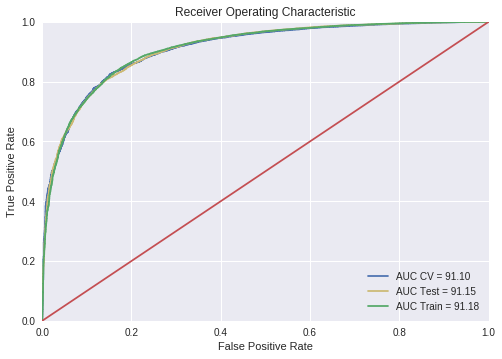

In [97]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [98]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.94


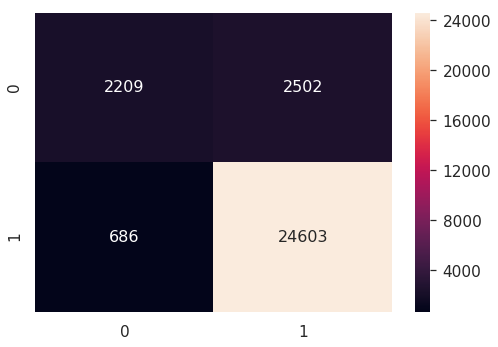

In [99]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [100]:
# Please write all the code with proper documentation

model = TfidfVectorizer()
#tf_idf_matrix = model.fit_transform(train)

print("================Train Data===========")
final_tf_idf_train = model.fit_transform(train)
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])
print("================CV Data===========")
final_tf_idf_cv = model.transform(cv)
print("the type of count vectorizer ",type(final_tf_idf_cv))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_cv.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_cv.get_shape()[1])
print("================Test Data===========")
final_tf_idf_test = model.transform(test)
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

================Train Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (49000, 43052)
the number of unique words including both unigrams and bigrams  43052
================CV Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (21000, 43052)
the number of unique words including both unigrams and bigrams  43052
================Test Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (30000, 43052)
the number of unique words including both unigrams and bigrams  43052


In [101]:
######## Train #######
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_train_sentance): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 49000/49000 [2:48:30<00:00,  4.85it/s]      


In [102]:
######## CV #######
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

cv_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_cv_sentance): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 21000/21000 [16:02<00:00, 15.38it/s]


In [103]:
######## Train #######
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_test_sentance): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 30000/30000 [24:36<00:00, 20.31it/s] 


In [104]:
# save the datasets as numpy array
tfidf_w2v_train = np.array(train_tfidf_sent_vectors)
tfidf_w2v_cv = np.array(cv_tfidf_sent_vectors)
tfidf_w2v_test = np.array(test_tfidf_sent_vectors)

### using L2 regularization

In [105]:
alpha = [pow(10,j) for j in range(-4,4,1)]

tfidf_w2v_train_auc = []
tfidf_w2v_cv_auc = []
for i in alpha:
    LSVM = SGDClassifier(loss='hinge',alpha=i, penalty='l2')
    calibrated_clf = CalibratedClassifierCV(LSVM, cv=5, method='sigmoid')
    calibrated_clf.fit(tfidf_w2v_train, train_y)
    # train data
    y_prob_train = calibrated_clf.predict_proba(tfidf_w2v_train)[:,1]
    y_pred = np.where(y_prob_train > 0.5, 1, 0)
    auc_roc_train = roc_auc_score(train_y , y_prob_train)
    print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
    tfidf_w2v_train_auc.append(auc_roc_train)
    # CV
    y_prob_cv = calibrated_clf.predict_proba(tfidf_w2v_cv)[:,1]
    y_pred = np.where(y_prob_cv > 0.5, 1, 0)
    auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
    print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
    tfidf_w2v_cv_auc.append(auc_roc_cv)
    print("="*50)


Train AUC for λ = 0.0001 is 88.49%

CV AUC for λ = 0.0001 is 88.65%

Train AUC for λ = 0.001 is 88.98%

CV AUC for λ = 0.001 is 88.99%

Train AUC for λ = 0.01 is 88.45%

CV AUC for λ = 0.01 is 88.45%

Train AUC for λ = 0.1 is 88.33%

CV AUC for λ = 0.1 is 88.31%

Train AUC for λ = 1 is 88.39%

CV AUC for λ = 1 is 88.41%

Train AUC for λ = 10 is 84.05%

CV AUC for λ = 10 is 84.13%

Train AUC for λ = 100 is 64.66%

CV AUC for λ = 100 is 64.65%

Train AUC for λ = 1000 is 64.66%

CV AUC for λ = 1000 is 64.65%


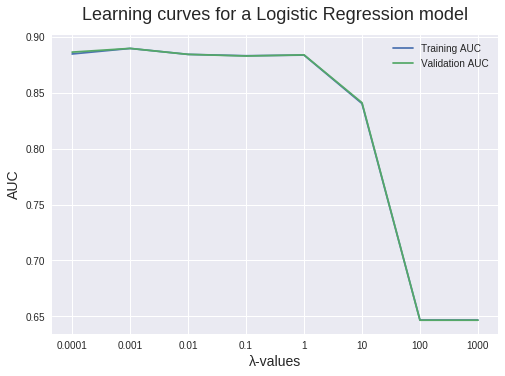

In [106]:
hyper = [str(pow(10,j)) for j in range(-4,4)]
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(hyper,tfidf_w2v_train_auc,label = 'Training AUC')
plt.plot(hyper, tfidf_w2v_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('\u03BB-values', fontsize = 14)
plt.title('Learning curves for a Logistic Regression model', fontsize = 18, y = 1.03)
plt.legend()

In [107]:
i = 0.001
LSVM = SGDClassifier(loss='hinge',alpha=i, penalty='l2')
calibrated_clf = CalibratedClassifierCV(LSVM, cv=5, method='sigmoid')
calibrated_clf.fit(tfidf_w2v_train, train_y)
# train data
y_prob_train = calibrated_clf.predict_proba(tfidf_w2v_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
# CV
y_prob_cv = calibrated_clf.predict_proba(tfidf_w2v_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
# Test
y_prob_test = calibrated_clf.predict_proba(tfidf_w2v_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))
                                              


Train AUC for λ = 0.001 is 88.91%

CV AUC for λ = 0.001 is 88.92%

Test AUC for λ = 0.001 is 89.07%


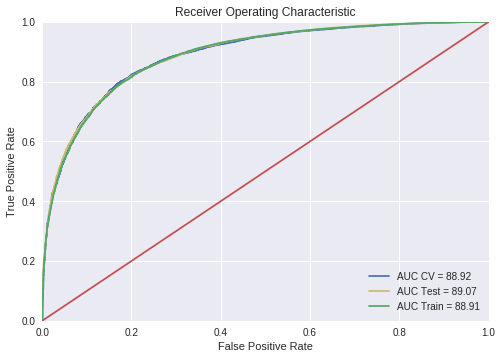

In [108]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [109]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.93


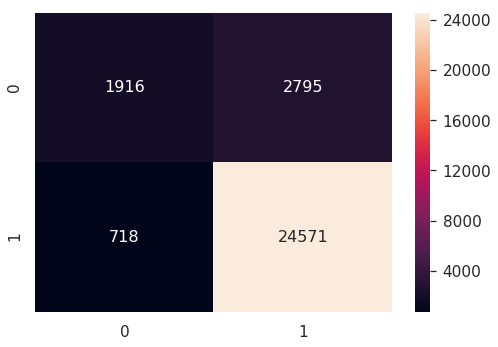

In [110]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

### L1 regulirization

In [111]:
alpha = [pow(10,j) for j in range(-4,4,1)]

tfidf_w2v_train_auc = []
tfidf_w2v_cv_auc = []
for i in alpha:
    LSVM = SGDClassifier(loss='hinge',alpha=i, penalty='l1')
    calibrated_clf = CalibratedClassifierCV(LSVM, cv=5, method='sigmoid')
    calibrated_clf.fit(tfidf_w2v_train, train_y)
    # train data
    y_prob_train = calibrated_clf.predict_proba(tfidf_w2v_train)[:,1]
    y_pred = np.where(y_prob_train > 0.5, 1, 0)
    auc_roc_train = roc_auc_score(train_y , y_prob_train)
    print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
    tfidf_w2v_train_auc.append(auc_roc_train)
    # CV
    y_prob_cv = calibrated_clf.predict_proba(tfidf_w2v_cv)[:,1]
    y_pred = np.where(y_prob_cv > 0.5, 1, 0)
    auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
    print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
    tfidf_w2v_cv_auc.append(auc_roc_cv)
    print("="*50)


Train AUC for λ = 0.0001 is 88.57%

CV AUC for λ = 0.0001 is 88.56%

Train AUC for λ = 0.001 is 88.57%

CV AUC for λ = 0.001 is 88.62%

Train AUC for λ = 0.01 is 82.15%

CV AUC for λ = 0.01 is 82.07%

Train AUC for λ = 0.1 is 50.00%

CV AUC for λ = 0.1 is 50.00%

Train AUC for λ = 1 is 50.00%

CV AUC for λ = 1 is 50.00%

Train AUC for λ = 10 is 50.00%

CV AUC for λ = 10 is 50.00%

Train AUC for λ = 100 is 50.00%

CV AUC for λ = 100 is 50.00%

Train AUC for λ = 1000 is 50.00%

CV AUC for λ = 1000 is 50.00%


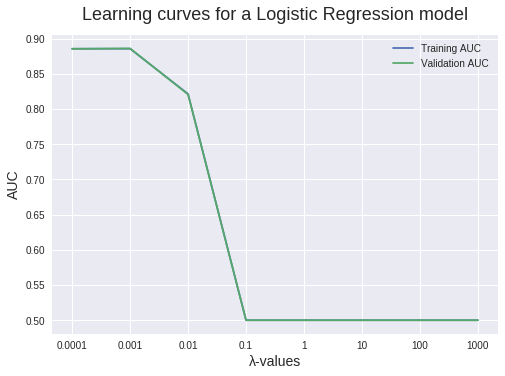

In [112]:
hyper = [str(pow(10,j)) for j in range(-4,4)]
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(hyper,tfidf_w2v_train_auc,label = 'Training AUC')
plt.plot(hyper, tfidf_w2v_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('\u03BB-values', fontsize = 14)
plt.title('Learning curves for a Logistic Regression model', fontsize = 18, y = 1.03)
plt.legend()

In [113]:
i = 0.001
LSVM = SGDClassifier(loss='hinge',alpha=i, penalty='l1')
calibrated_clf = CalibratedClassifierCV(LSVM, cv=5, method='sigmoid')
calibrated_clf.fit(w2v_train, train_y)
# train data
y_prob_train = calibrated_clf.predict_proba(w2v_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
# CV
y_prob_cv = calibrated_clf.predict_proba(w2v_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
# Test
y_prob_test = calibrated_clf.predict_proba(w2v_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))
                                              


Train AUC for λ = 0.001 is 90.75%

CV AUC for λ = 0.001 is 90.78%

Test AUC for λ = 0.001 is 90.90%


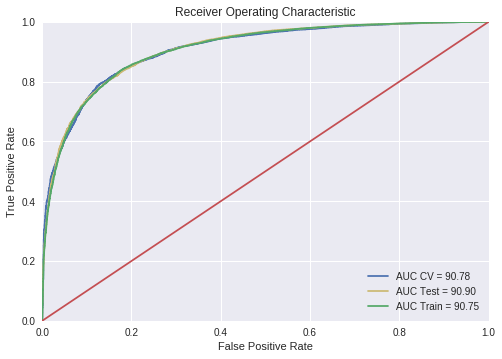

In [114]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [115]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.94


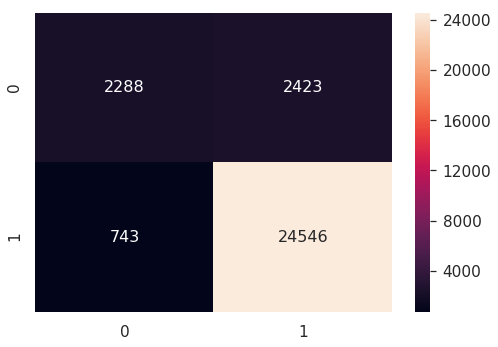

In [116]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

## [5.2] RBF SVM

### I am used to select 20k data points randaand sord them using time based splitting 

In [3]:
# Split the data into train , test and crossvalidation datasets
# load "preprocessed.pkl" data frame
df = pd.read_pickle("files/preprocessed.pkl")
df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational


In [4]:
# take 20k sample data randomly
sample_data = df.sample(20000)
sample_data.shape

(20000, 12)

In [5]:
# sorted the data using time based
sorted_data = sample_data.sort_values('Time', axis=0, inplace=False)
sorted_data.shape

(20000, 12)

In [6]:
X = np.array(sorted_data['CleanedText'])
y = np.array(sorted_data['Score'])
print(X.shape)
print(y.shape)

(20000,)
(20000,)


In [7]:
# Simple cross validation
# split the data sent into train and test
train , test , train_y , test_y = train_test_split(X, y, test_size = 0.3, random_state=None)

# split the train data set into cross validation train and cross validation test
train, cv , train_y, cv_y = train_test_split(train, train_y, test_size=0.3, random_state=None)

print("train data = ", train.shape)
print("cros validation = ", cv.shape)
print("test data = ", test.shape)

train data =  (9800,)
cros validation =  (4200,)
test data =  (6000,)


### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [149]:
# Please write all the code with proper documentation
#BoW
count_vect = CountVectorizer(min_df=10, max_features=500) #in scikit-learn
count_vect.fit(train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bow_train = count_vect.fit_transform(train)
bow_cv = count_vect.transform(cv)
bow_test = count_vect.transform(test)
print("============Train Data=========")
print("the type of count vectorizer ",type(bow_train))
print("the shape of out text BOW vectorizer ",bow_train.get_shape())
print("the number of unique words ", bow_train.get_shape()[1])
print("============Cross validation Data=========")
print("the type of count vectorizer ",type(bow_cv))
print("the shape of out text BOW vectorizer ",bow_cv.get_shape())
print("the number of unique words ", bow_cv.get_shape()[1])
print("============Test Data=========")
print("the type of count vectorizer ",type(bow_test))
print("the shape of out text BOW vectorizer ",bow_test.get_shape())
print("the number of unique words ", bow_test.get_shape()[1])

some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'adding', 'aftertaste', 'ago', 'almost', 'already']
============Train Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (9800, 500)
the number of unique words  500
============Cross validation Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4200, 500)
the number of unique words  500
============Test Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (6000, 500)
the number of unique words  500


In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit , GridSearchCV


In [170]:
C_range = list(np.logspace(-2, 10, 4))
gamma_range = list(np.logspace(-9, 3, 4))
bow_train_auc = []
bow_cv_auc = []
for i in C_range:
    for j in gamma_range:
        svc = SVC(C = i , gamma = j , probability=True)
        svc.fit(bow_train, train_y)
        # train data
        y_prob_train = svc.predict_proba(bow_train)[:,1]
        y_pred = np.where(y_prob_train > 0.5, 1, 0)
        auc_roc_train = roc_auc_score(train_y , y_prob_train)
        print('\nTrain AUC for \u03B3 = %s and C = %s is %0.2f%%' % (str(j),str(i),(auc_roc_train * float(100))))
        bow_train_auc.append(auc_roc_train)
        # CV
        y_prob_cv = svc.predict_proba(bow_cv)[:,1]
        y_pred = np.where(y_prob_cv > 0.5, 1, 0)
        auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
        print('\nCV AUC for \u03B3 = %s and C = %s is %0.2f%%' % (str(j),str(i),(auc_roc_cv * float(100))))
        bow_cv_auc.append(auc_roc_cv)
        print("="*50)


Train AUC for γ = 1e-09 and C = 0.01 is 50.00%

CV AUC for γ = 1e-09 and C = 0.01 is 50.00%

Train AUC for γ = 1e-05 and C = 0.01 is 75.32%

CV AUC for γ = 1e-05 and C = 0.01 is 74.61%

Train AUC for γ = 0.1 and C = 0.01 is 99.24%

CV AUC for γ = 0.1 and C = 0.01 is 85.85%

Train AUC for γ = 1000.0 and C = 0.01 is 0.21%

CV AUC for γ = 1000.0 and C = 0.01 is 49.89%

Train AUC for γ = 1e-09 and C = 100.0 is 71.75%

CV AUC for γ = 1e-09 and C = 100.0 is 72.45%

Train AUC for γ = 1e-05 and C = 100.0 is 90.41%

CV AUC for γ = 1e-05 and C = 100.0 is 89.38%

Train AUC for γ = 0.1 and C = 100.0 is 99.96%

CV AUC for γ = 0.1 and C = 100.0 is 85.36%

Train AUC for γ = 1000.0 and C = 100.0 is 0.17%

CV AUC for γ = 1000.0 and C = 100.0 is 49.89%

Train AUC for γ = 1e-09 and C = 1000000.0 is 71.36%

CV AUC for γ = 1e-09 and C = 1000000.0 is 72.01%

Train AUC for γ = 1e-05 and C = 1000000.0 is 92.03%

CV AUC for γ = 1e-05 and C = 1000000.0 is 88.38%

Train AUC for γ = 0.1 and C = 1000000.0 is 99.9

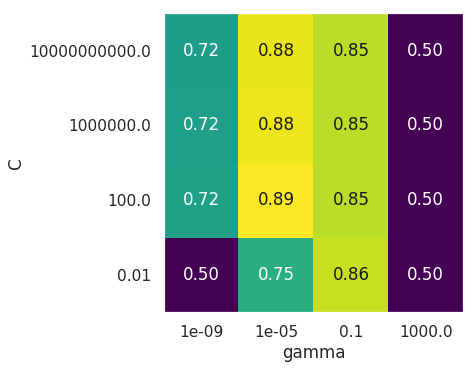

In [174]:
scores = np.array(bow_cv_auc).reshape(len(C_range),len(gamma_range))
# plot the mean cross-validation scores  
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=gamma_range,  
                      ylabel='C', yticklabels=C_range, cmap="viridis")  


In [176]:
i = 100
j = 1e-05
svc = SVC(C = i , gamma = j , probability=True)
svc.fit(bow_train, train_y)
# train data
y_prob_train = svc.predict_proba(bow_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03B3 = %s and C = %s is %0.2f%%' % (str(j),str(i),(auc_roc_train * float(100))))
# CV
y_prob_cv = svc.predict_proba(bow_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03B3 = %s and C = %s is %0.2f%%' % (str(j),str(i),(auc_roc_cv * float(100))))
# Test
y_prob_test = svc.predict_proba(bow_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03B3 = %s and C = %s is %0.2f%%' % (str(j),str(i),(auc_roc_test * float(100))))


Train AUC for γ = 1e-05 and C = 100 is 90.41%

CV AUC for γ = 1e-05 and C = 100 is 89.38%

Test AUC for γ = 1e-05 and C = 100 is 86.75%


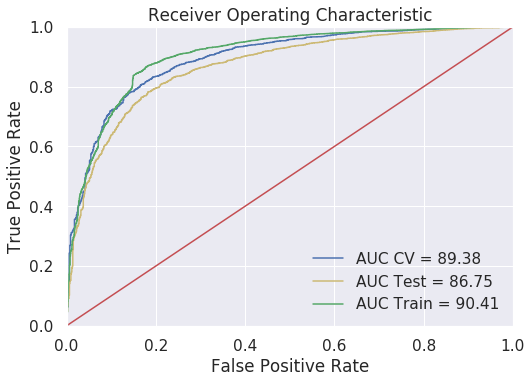

In [177]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [178]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.93


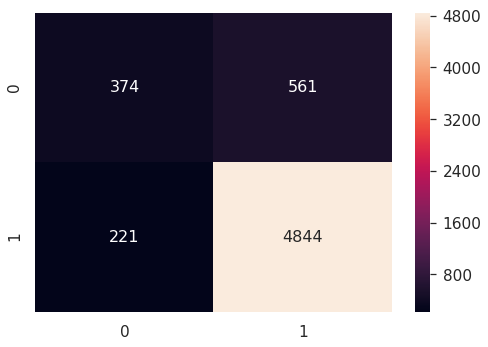

In [179]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [186]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation

model = TfidfVectorizer(min_df=10, ngram_range=(1,2), max_features=500)
#tf_idf_matrix = model.fit_transform(train)

print("================Train Data===========")
tf_idf_train = model.fit_transform(train)
print("the type of count vectorizer ",type(tf_idf_train))
print("the shape of out text TFIDF vectorizer ",tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ",tf_idf_train.get_shape()[1])
print("================CV Data===========")
tf_idf_cv = model.transform(cv)
print("the type of count vectorizer ",type(tf_idf_cv))
print("the shape of out text TFIDF vectorizer ",tf_idf_cv.get_shape())
print("the number of unique words including both unigrams and bigrams ",tf_idf_cv.get_shape()[1])
print("================Test Data===========")
tf_idf_test = model.transform(test)
print("the type of count vectorizer ",type(tf_idf_test))
print("the shape of out text TFIDF vectorizer ",tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", tf_idf_test.get_shape()[1])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

================Train Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (9800, 500)
the number of unique words including both unigrams and bigrams  500
================CV Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4200, 500)
the number of unique words including both unigrams and bigrams  500
================Test Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (6000, 500)
the number of unique words including both unigrams and bigrams  500


In [187]:
C_range = list(np.logspace(-2, 10, 4))
gamma_range = list(np.logspace(-9, 3, 4))
tfidf_train_auc = []
tfidf_cv_auc = []
for i in C_range:
    for j in gamma_range:
        svc = SVC(C = i , gamma = j , probability=True)
        svc.fit(tf_idf_train, train_y)
        # train data
        y_prob_train = svc.predict_proba(tf_idf_train)[:,1]
        y_pred = np.where(y_prob_train > 0.5, 1, 0)
        auc_roc_train = roc_auc_score(train_y , y_prob_train)
        print('\nTrain AUC for \u03B3 = %s and C = %s is %0.2f%%' % (str(j),str(i),(auc_roc_train * float(100))))
        tfidf_train_auc.append(auc_roc_train)
        # CV
        y_prob_cv = svc.predict_proba(tf_idf_cv)[:,1]
        y_pred = np.where(y_prob_cv > 0.5, 1, 0)
        auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
        print('\nCV AUC for \u03B3 = %s and C = %s is %0.2f%%' % (str(j),str(i),(auc_roc_cv * float(100))))
        tfidf_cv_auc.append(auc_roc_cv)
        print("="*50)


Train AUC for γ = 1e-09 and C = 0.01 is 50.31%

CV AUC for γ = 1e-09 and C = 0.01 is 16.63%

Train AUC for γ = 1e-05 and C = 0.01 is 49.79%

CV AUC for γ = 1e-05 and C = 0.01 is 82.97%

Train AUC for γ = 0.1 and C = 0.01 is 49.58%

CV AUC for γ = 0.1 and C = 0.01 is 88.05%

Train AUC for γ = 1000.0 and C = 0.01 is 50.03%

CV AUC for γ = 1000.0 and C = 0.01 is 49.91%

Train AUC for γ = 1e-09 and C = 100.0 is 49.70%

CV AUC for γ = 1e-09 and C = 100.0 is 83.37%

Train AUC for γ = 1e-05 and C = 100.0 is 50.12%

CV AUC for γ = 1e-05 and C = 100.0 is 88.05%

Train AUC for γ = 0.1 and C = 100.0 is 49.89%

CV AUC for γ = 0.1 and C = 100.0 is 89.10%

Train AUC for γ = 1000.0 and C = 100.0 is 50.03%

CV AUC for γ = 1000.0 and C = 100.0 is 49.91%

Train AUC for γ = 1e-09 and C = 1000000.0 is 49.69%

CV AUC for γ = 1e-09 and C = 1000000.0 is 83.37%

Train AUC for γ = 1e-05 and C = 1000000.0 is 49.85%

CV AUC for γ = 1e-05 and C = 1000000.0 is 87.81%

Train AUC for γ = 0.1 and C = 1000000.0 is 49

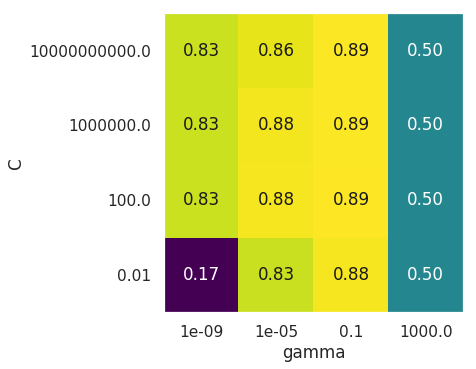

In [189]:
scores = np.array(tfidf_cv_auc).reshape(len(C_range),len(gamma_range))
# plot the mean cross-validation scores  
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=gamma_range,  
                      ylabel='C', yticklabels=C_range, cmap="viridis")  

In [191]:
i = 100
j = 0.1
svc = SVC(C = i , gamma = j , probability=True)
svc.fit(tf_idf_train, train_y)
# train data
y_prob_train = svc.predict_proba(tf_idf_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03B3 = %s and C = %s is %0.2f%%' % (str(j),str(i),(auc_roc_train * float(100))))
# CV
y_prob_cv = svc.predict_proba(tf_idf_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03B3 = %s and C = %s is %0.2f%%' % (str(j),str(i),(auc_roc_cv * float(100))))
# Test
y_prob_test = svc.predict_proba(tf_idf_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03B3 = %s and C = %s is %0.2f%%' % (str(j),str(i),(auc_roc_test * float(100))))


Train AUC for γ = 0.1 and C = 100 is 99.89%

CV AUC for γ = 0.1 and C = 100 is 89.10%

Test AUC for γ = 0.1 and C = 100 is 89.04%


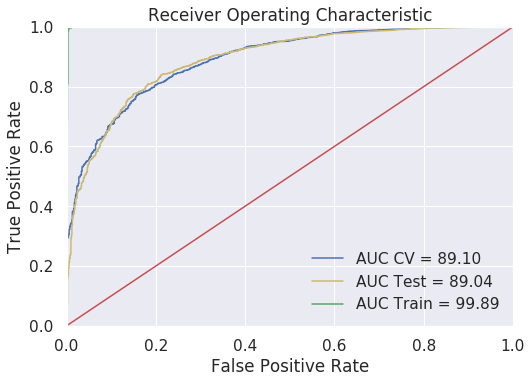

In [193]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [194]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.94


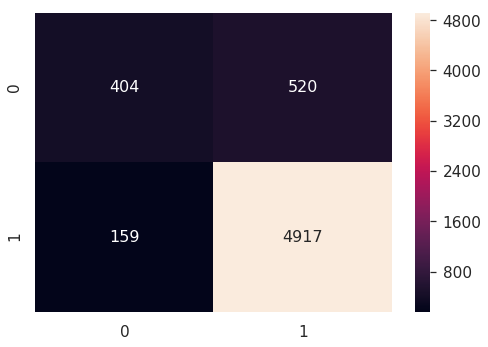

In [195]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [9]:
# Please write all the code with proper documentation
# Train your own Word2Vec model using your own text corpus
######## Train Set #########
i=0
list_of_train_sentance=[]
for sentance in train:
    list_of_train_sentance.append(sentance.split())
######## CV Set ###########
i=0
list_of_cv_sentance=[]
for sentance in cv:
    list_of_cv_sentance.append(sentance.split())
######## Test Set #########
i=0
list_of_test_sentance=[]
for sentance in test:
    list_of_test_sentance.append(sentance.split())
print("Length of Train = ", len(list_of_train_sentance))
print("Length of CV = ", len(list_of_cv_sentance))
print("Length of Test = ", len(list_of_test_sentance))

Length of Train =  9800
Length of CV =  4200
Length of Test =  6000


In [10]:
w2v_model=Word2Vec(list_of_train_sentance,min_count=15,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

[('excellent', 0.8764510750770569), ('good', 0.8501964807510376), ('especially', 0.8444511890411377), ('value', 0.7707410454750061), ('overall', 0.7634857892990112), ('beat', 0.73881995677948), ('awesome', 0.7380631566047668), ('makes', 0.7195237278938293), ('wonderful', 0.7189063429832458), ('super', 0.7186911702156067)]
[('american', 0.9778188467025757), ('none', 0.9739011526107788), ('favorites', 0.9726344347000122), ('gourmet', 0.9720492959022522), ('admit', 0.9717141389846802), ('gu', 0.9709646701812744), ('southern', 0.9701089859008789), ('snob', 0.9699053764343262), ('greatest', 0.9695760607719421), ('reviewer', 0.9690815210342407)]


In [11]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  2955
sample words  ['smell', 'coming', 'cans', 'bought', 'three', 'separate', 'bad', 'thought', 'would', 'go', 'organic', 'apparently', 'necessary', 'not', 'buy', 'used', 'product', 'many', 'years', 'went', 'local', 'told', 'company', 'business', 'could', 'get', 'anymore', 'amazon', 'com', 'someone', 'tells', 'everything', 'called', 'quaker', 'oats', 'vendor', 'charge', 'selling', 'gave', 'website', 'contacted', 'sure', 'still', 'make', 'lazy', 'discontinued', 'ordered', 'cheaper', 'almost', 'dollar']


In [12]:
######## Train data ########
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_train_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 9800/9800 [00:19<00:00, 502.95it/s]

9800
50


In [13]:
######## CV data ########
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_cv_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|██████████| 4200/4200 [00:08<00:00, 472.86it/s]

4200
50


In [14]:
######## Test data ########
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_test_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 6000/6000 [00:12<00:00, 482.55it/s]

6000
50


In [15]:
# save the datasets as numpy array
w2v_train = np.array(sent_vectors_train)
w2v_cv = np.array(sent_vectors_cv)
w2v_test = np.array(sent_vectors_test)

In [16]:
C_range = [pow(10,j) for j in range(-2,2,1)]
gamma_range = [pow(10,j) for j in range(-2,2,1)]
w2v_train_auc = []
w2v_cv_auc = []
for i in C_range:
    for j in gamma_range:
        svc = SVC(C = i , gamma = j , probability=True)
        svc.fit(w2v_train, train_y)
        # train data
        y_prob_train = svc.predict_proba(w2v_train)[:,1]
        y_pred = np.where(y_prob_train > 0.5, 1, 0)
        auc_roc_train = roc_auc_score(train_y , y_prob_train)
        print('\nTrain AUC for \u03B3 = %s and C = %s is %0.2f%%' % (str(j),str(i),(auc_roc_train * float(100))))
        w2v_train_auc.append(auc_roc_train)
        # CV
        y_prob_cv = svc.predict_proba(w2v_cv)[:,1]
        y_pred = np.where(y_prob_cv > 0.5, 1, 0)
        auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
        print('\nCV AUC for \u03B3 = %s and C = %s is %0.2f%%' % (str(j),str(i),(auc_roc_cv * float(100))))
        w2v_cv_auc.append(auc_roc_cv)
        print("="*50)


Train AUC for γ = 0.01 and C = 0.01 is 82.13%

CV AUC for γ = 0.01 and C = 0.01 is 81.95%

Train AUC for γ = 0.1 and C = 0.01 is 86.04%

CV AUC for γ = 0.1 and C = 0.01 is 84.35%

Train AUC for γ = 1 and C = 0.01 is 87.31%

CV AUC for γ = 1 and C = 0.01 is 83.03%

Train AUC for γ = 10 and C = 0.01 is 99.18%

CV AUC for γ = 10 and C = 0.01 is 74.43%

Train AUC for γ = 0.01 and C = 0.1 is 85.53%

CV AUC for γ = 0.01 and C = 0.1 is 84.10%

Train AUC for γ = 0.1 and C = 0.1 is 87.01%

CV AUC for γ = 0.1 and C = 0.1 is 85.06%

Train AUC for γ = 1 and C = 0.1 is 87.39%

CV AUC for γ = 1 and C = 0.1 is 83.07%

Train AUC for γ = 10 and C = 0.1 is 99.17%

CV AUC for γ = 10 and C = 0.1 is 74.44%

Train AUC for γ = 0.01 and C = 1 is 86.89%

CV AUC for γ = 0.01 and C = 1 is 85.02%

Train AUC for γ = 0.1 and C = 1 is 87.07%

CV AUC for γ = 0.1 and C = 1 is 85.10%

Train AUC for γ = 1 and C = 1 is 88.10%

CV AUC for γ = 1 and C = 1 is 83.34%

Train AUC for γ = 10 and C = 1 is 99.60%

CV AUC for γ =

In [1]:
import mglearn

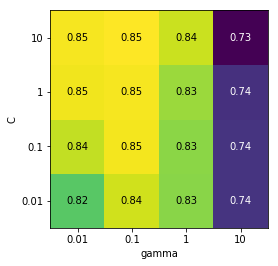

In [20]:
scores = np.array(w2v_cv_auc).reshape(len(C_range),len(gamma_range))
# plot the mean cross-validation scores  
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=gamma_range,  
                      ylabel='C', yticklabels=C_range, cmap="viridis")  

In [21]:
i = 10
j = 0.1
svc = SVC(C = i , gamma = j , probability=True)
svc.fit(w2v_train, train_y)
# train data
y_prob_train = svc.predict_proba(w2v_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03B3 = %s and C = %s is %0.2f%%' % (str(j),str(i),(auc_roc_train * float(100))))
# CV
y_prob_cv = svc.predict_proba(w2v_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03B3 = %s and C = %s is %0.2f%%' % (str(j),str(i),(auc_roc_cv * float(100))))
# Test
y_prob_test = svc.predict_proba(w2v_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03B3 = %s and C = %s is %0.2f%%' % (str(j),str(i),(auc_roc_test * float(100))))


Train AUC for γ = 0.1 and C = 10 is 87.24%

CV AUC for γ = 0.1 and C = 10 is 85.27%

Test AUC for γ = 0.1 and C = 10 is 85.45%


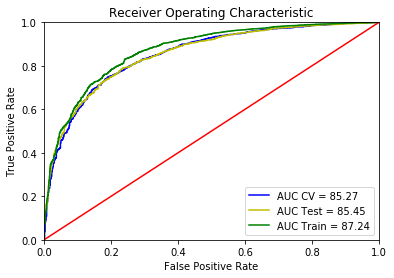

In [22]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [23]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.93


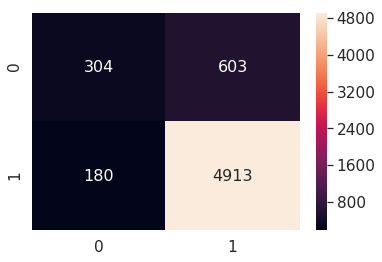

In [24]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [26]:
# Please write all the code with proper documentation

model = TfidfVectorizer(min_df=10 , max_features=500, ngram_range=(1,2))
#tf_idf_matrix = model.fit_transform(train)

print("================Train Data===========")
final_tf_idf_train = model.fit_transform(train)
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])
print("================CV Data===========")
final_tf_idf_cv = model.transform(cv)
print("the type of count vectorizer ",type(final_tf_idf_cv))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_cv.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_cv.get_shape()[1])
print("================Test Data===========")
final_tf_idf_test = model.transform(test)
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

================Train Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (9800, 500)
the number of unique words including both unigrams and bigrams  500
================CV Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4200, 500)
the number of unique words including both unigrams and bigrams  500
================Test Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (6000, 500)
the number of unique words including both unigrams and bigrams  500


In [28]:
######## Train #######
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_train_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 9800/9800 [00:26<00:00, 373.16it/s]


In [29]:
######## CV #######
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

cv_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_cv_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 4200/4200 [00:10<00:00, 397.58it/s]


In [31]:
######## Train #######
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_test_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 6000/6000 [00:16<00:00, 358.53it/s]


In [32]:
# save the datasets as numpy array
tfidf_w2v_train = np.array(train_tfidf_sent_vectors)
tfidf_w2v_cv = np.array(cv_tfidf_sent_vectors)
tfidf_w2v_test = np.array(test_tfidf_sent_vectors)

In [34]:
C_range = [pow(10,j) for j in range(-4,3,1)]
gamma_range = [pow(10,j) for j in range(-4,3,1)]
tfidf_w2v_train_auc = []
tfidf_w2v_cv_auc = []
for i in C_range:
    for j in gamma_range:
        svc = SVC(C = i , gamma = j , probability=True)
        svc.fit(tfidf_w2v_train, train_y)
        # train data
        y_prob_train = svc.predict_proba(tfidf_w2v_train)[:,1]
        y_pred = np.where(y_prob_train > 0.5, 1, 0)
        auc_roc_train = roc_auc_score(train_y , y_prob_train)
        print('\nTrain AUC for \u03B3 = %s and C = %s is %0.2f%%' % (str(j),str(i),(auc_roc_train * float(100))))
        tfidf_w2v_train_auc.append(auc_roc_train)
        # CV
        y_prob_cv = svc.predict_proba(tfidf_w2v_cv)[:,1]
        y_pred = np.where(y_prob_cv > 0.5, 1, 0)
        auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
        print('\nCV AUC for \u03B3 = %s and C = %s is %0.2f%%' % (str(j),str(i),(auc_roc_cv * float(100))))
        tfidf_w2v_cv_auc.append(auc_roc_cv)
        print("="*50)


Train AUC for γ = 0.0001 and C = 0.0001 is 50.00%

CV AUC for γ = 0.0001 and C = 0.0001 is 50.00%

Train AUC for γ = 0.001 and C = 0.0001 is 75.05%

CV AUC for γ = 0.001 and C = 0.0001 is 72.48%

Train AUC for γ = 0.01 and C = 0.0001 is 75.93%

CV AUC for γ = 0.01 and C = 0.0001 is 73.40%

Train AUC for γ = 0.1 and C = 0.0001 is 71.06%

CV AUC for γ = 0.1 and C = 0.0001 is 69.93%

Train AUC for γ = 1 and C = 0.0001 is 67.47%

CV AUC for γ = 1 and C = 0.0001 is 64.72%

Train AUC for γ = 10 and C = 0.0001 is 98.53%

CV AUC for γ = 10 and C = 0.0001 is 56.96%

Train AUC for γ = 100 and C = 0.0001 is 99.94%

CV AUC for γ = 100 and C = 0.0001 is 52.95%

Train AUC for γ = 0.0001 and C = 0.001 is 75.25%

CV AUC for γ = 0.0001 and C = 0.001 is 72.68%

Train AUC for γ = 0.001 and C = 0.001 is 75.05%

CV AUC for γ = 0.001 and C = 0.001 is 72.48%

Train AUC for γ = 0.01 and C = 0.001 is 77.59%

CV AUC for γ = 0.01 and C = 0.001 is 76.06%

Train AUC for γ = 0.1 and C = 0.001 is 81.17%

CV AUC for

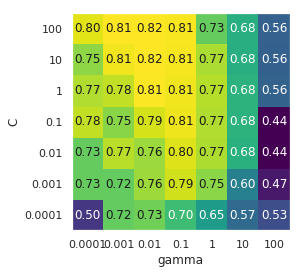

In [42]:
scores = np.array(tfidf_w2v_cv_auc).reshape(len(C_range),len(gamma_range))
# plot the mean cross-validation scores  
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=gamma_range,  
                      ylabel='C', yticklabels=C_range, cmap="viridis")

In [43]:
i = 10
j = 0.1
svc = SVC(C = i , gamma = j , probability=True)
svc.fit(tfidf_w2v_train, train_y)
# train data
y_prob_train = svc.predict_proba(tfidf_w2v_train)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03B3 = %s and C = %s is %0.2f%%' % (str(j),str(i),(auc_roc_train * float(100))))
# CV
y_prob_cv = svc.predict_proba(tfidf_w2v_cv)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03B3 = %s and C = %s is %0.2f%%' % (str(j),str(i),(auc_roc_cv * float(100))))
# Test
y_prob_test = svc.predict_proba(tfidf_w2v_test)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03B3 = %s and C = %s is %0.2f%%' % (str(j),str(i),(auc_roc_test * float(100))))


Train AUC for γ = 0.1 and C = 10 is 86.04%

CV AUC for γ = 0.1 and C = 10 is 80.94%

Test AUC for γ = 0.1 and C = 10 is 81.09%


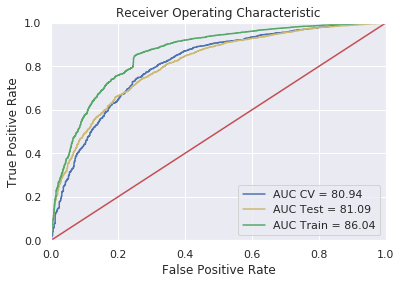

In [44]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [45]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.92


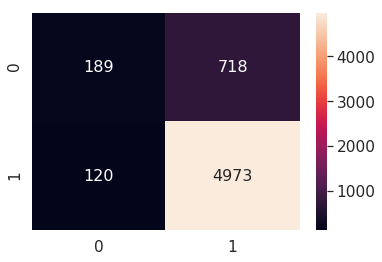

In [46]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

In [55]:
# Please compare all your models using Prettytable library
X_review = np.array(sorted_data['CleanedText'])
X_summary = np.array(sorted_data['Summary'])
y = np.array(sorted_data['Score'])
print(X_review.shape)
print(X_summary.shape)
print(y.shape)

(100000,)
(100000,)
(100000,)


In [56]:
# Simple cross validation
# split the data sent into train and test
train_review , test_review, train_summary, test_summary , train_y , test_y = train_test_split(X_review,X_summary, y, test_size = 0.3, random_state=None)

# split the train data set into cross validation train and cross validation test
train_review, cv_review, train_summary, cv_summary , train_y, cv_y = train_test_split(train_review, train_summary, train_y, test_size=0.3, random_state=None)

print("train review", train_review.shape)
print("cv review", cv_review.shape)
print("test review", test_review.shape)
print("train summary", train_summary.shape)
print("cv summary", cv_summary.shape)
print("test summary", test_summary.shape)

train review (49000,)
cv review (21000,)
test review (30000,)
train summary (49000,)
cv summary (21000,)
test summary (30000,)


In [59]:
# bow for summary
# Please write all the code with proper documentation
#BoW
count_vect = CountVectorizer(min_df=15, ngram_range=(1,2)) #in scikit-learn
count_vect.fit(train_summary)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bow_train_summary = count_vect.fit_transform(train_summary)
bow_cv_summary = count_vect.transform(cv_summary)
bow_test_summary = count_vect.transform(test_summary)
print("============Train Data=========")
print("the type of count vectorizer ",type(bow_train_summary))
print("the shape of out text BOW vectorizer ",bow_train_summary.get_shape())
print("the number of unique words ", bow_train_summary.get_shape()[1])
print("============Cross validation Data=========")
print("the type of count vectorizer ",type(bow_cv_summary))
print("the shape of out text BOW vectorizer ",bow_cv_summary.get_shape())
print("the number of unique words ", bow_cv_summary.get_shape()[1])
print("============Test Data=========")
print("the type of count vectorizer ",type(bow_test_summary))
print("the shape of out text BOW vectorizer ",bow_test_summary.get_shape())
print("the number of unique words ", bow_test_summary.get_shape()[1])

some feature names  ['10', '100', '12', '15', '20', '24', '50', 'about', 'about it', 'about the']
============Train Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (49000, 2299)
the number of unique words  2299
============Cross validation Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (21000, 2299)
the number of unique words  2299
============Test Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (30000, 2299)
the number of unique words  2299


In [62]:
alpha = [pow(10,j) for j in range(-4,4,1)]

bow_train_auc = []
bow_cv_auc = []
for i in alpha:
    LSVM = SGDClassifier(loss='hinge',alpha=i, penalty='l2')
    calibrated_clf = CalibratedClassifierCV(LSVM, cv=5, method='sigmoid')
    calibrated_clf.fit(bow_train_summary, train_y)
    # train data
    y_prob_train = calibrated_clf.predict_proba(bow_train_summary)[:,1]
    y_pred = np.where(y_prob_train > 0.5, 1, 0)
    auc_roc_train = roc_auc_score(train_y , y_prob_train)
    print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
    bow_train_auc.append(auc_roc_train)
    # CV
    y_prob_cv = calibrated_clf.predict_proba(bow_cv_summary)[:,1]
    y_pred = np.where(y_prob_cv > 0.5, 1, 0)
    auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
    print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
    bow_cv_auc.append(auc_roc_cv)
    print("="*50)



Train AUC for λ = 0.0001 is 94.04%

CV AUC for λ = 0.0001 is 92.10%

Train AUC for λ = 0.001 is 92.38%

CV AUC for λ = 0.001 is 91.07%

Train AUC for λ = 0.01 is 91.13%

CV AUC for λ = 0.01 is 89.95%

Train AUC for λ = 0.1 is 75.82%

CV AUC for λ = 0.1 is 75.30%

Train AUC for λ = 1 is 69.94%

CV AUC for λ = 1 is 69.41%

Train AUC for λ = 10 is 69.94%

CV AUC for λ = 10 is 69.41%

Train AUC for λ = 100 is 69.94%

CV AUC for λ = 100 is 69.41%

Train AUC for λ = 1000 is 69.94%

CV AUC for λ = 1000 is 69.41%


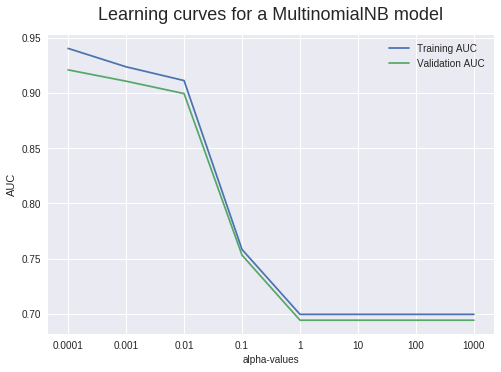

In [64]:
hyper = [str(pow(10,j)) for j in range(-4,4)]
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(hyper,bow_train_auc,label = 'Training AUC')
plt.plot(hyper, bow_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC')
plt.xlabel('alpha-values', fontsize = 10)
plt.title('Learning curves for a MultinomialNB model', fontsize = 18, y = 1.03)
plt.legend()

In [65]:
# summary text
i = 0.0001
LSVM = SGDClassifier(loss='hinge',alpha=i, penalty='l2')
calibrated_clf = CalibratedClassifierCV(LSVM, cv=5, method='sigmoid')
calibrated_clf.fit(bow_train_summary, train_y)
# train data
y_prob_train = calibrated_clf.predict_proba(bow_train_summary)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
# CV
y_prob_cv = calibrated_clf.predict_proba(bow_cv_summary)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
# Test
y_prob_test = calibrated_clf.predict_proba(bow_test_summary)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))
                                              


Train AUC for λ = 0.0001 is 94.21%

CV AUC for λ = 0.0001 is 92.34%

Test AUC for λ = 0.0001 is 92.48%


In [66]:
# bow for review
# Please write all the code with proper documentation
#BoW
count_vect = CountVectorizer(min_df=15, ngram_range=(1,2)) #in scikit-learn
count_vect.fit(train_review)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bow_train_review = count_vect.fit_transform(train_review)
bow_cv_review = count_vect.transform(cv_review)
bow_test_review = count_vect.transform(test_review)
print("============Train Data=========")
print("the type of count vectorizer ",type(bow_train_review))
print("the shape of out text BOW vectorizer ",bow_train_review.get_shape())
print("the number of unique words ", bow_train_review.get_shape()[1])
print("============Cross validation Data=========")
print("the type of count vectorizer ",type(bow_cv_review))
print("the shape of out text BOW vectorizer ",bow_cv_review.get_shape())
print("the number of unique words ", bow_cv_review.get_shape()[1])
print("============Test Data=========")
print("the type of count vectorizer ",type(bow_test_review))
print("the shape of out text BOW vectorizer ",bow_test_review.get_shape())
print("the number of unique words ", bow_test_review.get_shape()[1])

some feature names  ['ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able get', 'able give', 'able make']
============Train Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (49000, 18421)
the number of unique words  18421
============Cross validation Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (21000, 18421)
the number of unique words  18421
============Test Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (30000, 18421)
the number of unique words  18421


In [67]:
# bow for review
i = 0.0001
LSVM = SGDClassifier(loss='hinge',alpha=i, penalty='l1')
calibrated_clf = CalibratedClassifierCV(LSVM, cv=5, method='sigmoid')
calibrated_clf.fit(bow_train_review, train_y)
# train data
y_prob_train = calibrated_clf.predict_proba(bow_train_review)[:,1]
fprt, tprt, throsholdt = roc_curve(train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(train_y , y_prob_train)
print('\nTrain AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_train * float(100))))
# CV
y_prob_cv = calibrated_clf.predict_proba(bow_cv_review)[:,1]
fprc, tprc, throsholdc = roc_curve(cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(cv_y , y_prob_cv)
print('\nCV AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_cv * float(100))))
# Test
y_prob_test_review = calibrated_clf.predict_proba(bow_test_review)[:,1]
fprts, tprts, throsholdts = roc_curve(test_y, y_prob_test_review)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , y_prob_test)
print('\nTest AUC for \u03BB = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))
                                              


Train AUC for λ = 0.0001 is 96.88%

CV AUC for λ = 0.0001 is 94.20%

Test AUC for λ = 0.0001 is 92.48%


In [68]:
# adding both summary and review test probabilitys and average
new_proba = (y_prob_test_review + y_prob_test) / 2

In [69]:
fprts, tprts, throsholdts = roc_curve(test_y, new_proba)
y_pred_test = np.where(new_proba > 0.5, 1, 0)
auc_roc_test = roc_auc_score(test_y , new_proba)
print('\nTest AUC for alpha = %s is %0.2f%%' % (str(i), (auc_roc_test * float(100))))


Test AUC for alpha = 0.0001 is 97.16%


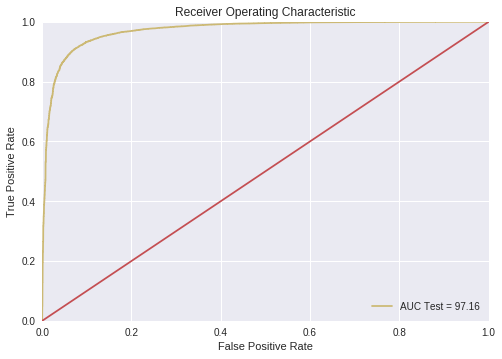

In [70]:
import matplotlib.pyplot as plt
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [71]:
print("F1-Score on test set: %0.2f"%(f1_score(test_y, y_pred_test)))

F1-Score on test set: 0.96


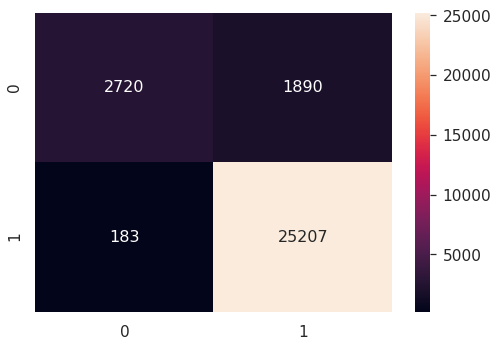

In [72]:
df_cm = pd.DataFrame(confusion_matrix(test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

***Observation :*** : adding two models we get better results. we see the 97.16% AUC and F1 score is 0.96

# [6] Conclusions

## Linear SVM

In [73]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
x = PrettyTable(["Vectorizer" , "Regularization","Hyper parameter \u03BB", "AUC", "F1 Score"])

x.add_row(["BOW", "L2" ,0.001, "93.92%", 0.95])
x.add_row(["BOW","L1" , 0.0001,"93.07%", 0.95])
x.add_row(["TFIDF", "L2" ,0.0001, "95.82%", 0.96])
x.add_row(["TFIDF","L1" , 0.0001,"93.97%", 0.95])
x.add_row(["AVG-W2V", "L2" ,0.0001, "91.97%", 0.94])
x.add_row(["AVG-W2V","L1" , 0.0001,"91.15%", 0.94])
x.add_row(["TFIDF-W2V", "L2" ,0.001, "89.07%", 0.94])
x.add_row(["TFIDF-W2V","L1" , 0.001,"91.06%", 0.94])

print(x.get_string(title="Linear SVM"))

+------------+----------------+-------------------+--------+----------+
| Vectorizer | Regularization | Hyper parameter λ |  AUC   | F1 Score |
+------------+----------------+-------------------+--------+----------+
|    BOW     |       L2       |       0.001       | 93.92% |   0.95   |
|    BOW     |       L1       |       0.0001      | 93.07% |   0.95   |
|   TFIDF    |       L2       |       0.0001      | 95.82% |   0.96   |
|   TFIDF    |       L1       |       0.0001      | 93.97% |   0.95   |
|  AVG-W2V   |       L2       |       0.0001      | 91.97% |   0.94   |
|  AVG-W2V   |       L1       |       0.0001      | 91.15% |   0.94   |
| TFIDF-W2V  |       L2       |       0.001       | 89.07% |   0.94   |
| TFIDF-W2V  |       L1       |       0.001       | 91.06% |   0.94   |
+------------+----------------+-------------------+--------+----------+


## RBF

In [74]:
x = PrettyTable(["Vectorizer","Hyper parameter C", "gamma", "AUC", "F1 Score"])

x.add_row(["BOW" ,100,"le-05" ,"86.72%", 0.93])
x.add_row(["TFIDF" ,100,0.1 ,"89.04%", 0.94])
x.add_row(["AVG-W2V",10 ,0.1, "85.45%", 0.93])
x.add_row(["TFIDF-W2V",10 ,0.1, "81.09%", 0.92])

print(x.get_string(title="RBF SVM"))

+------------+-------------------+-------+--------+----------+
| Vectorizer | Hyper parameter C | gamma |  AUC   | F1 Score |
+------------+-------------------+-------+--------+----------+
|    BOW     |        100        | le-05 | 86.72% |   0.93   |
|   TFIDF    |        100        |  0.1  | 89.04% |   0.94   |
|  AVG-W2V   |         10        |  0.1  | 85.45% |   0.93   |
| TFIDF-W2V  |         10        |  0.1  | 81.09% |   0.92   |
+------------+-------------------+-------+--------+----------+


## Feature engineering

In [75]:
x = PrettyTable(["Feature" , "Vectorizer" , "Regularization","Hyper parameter \u03BB", "AUC", "F1 Score"])

x.add_row(["Test length", "BOW", "L2", 0.0001, "92.48%", 0.95])
x.add_row(["Summary + Review", "BOW", "L2",0.0001 , "97.16%", 0.97])

print(x.get_string(title="Linear SVM Model"))

+------------------+------------+----------------+-------------------+--------+----------+
|     Feature      | Vectorizer | Regularization | Hyper parameter λ |  AUC   | F1 Score |
+------------------+------------+----------------+-------------------+--------+----------+
|   Test length    |    BOW     |       L2       |       0.0001      | 92.48% |   0.95   |
| Summary + Review |    BOW     |       L2       |       0.0001      | 97.16% |   0.97   |
+------------------+------------+----------------+-------------------+--------+----------+
